### Cats vs. Dogs
* Download Kaggle Cats and Dogs Dataset : https://www.microsoft.com/en-us/download/details.aspx?id=54765

### Import

In [1]:
import os
import cv2
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Check if pytorch is using GPU "GeForce GTX 1060"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

assert torch.cuda.get_device_name(0) == "GeForce GTX 1060"

### Hyper-parameters

In [3]:
EPOCHS = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

### Data preprocessing

In [4]:
class Dataset():
    IMG_SIZE = 50
    CATS = "../dataset/PetImages/Cat"
    DOGS = "../dataset/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} 
    training_data = []
    
    def make_training_data(self):
        
        for label in self.LABELS:
                for file in tqdm(os.listdir(label)):
                    try:
                        path = os.path.join(label, file)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    except Exception as e:
                        #print(str(e))
                        pass
        
        np.random.shuffle(self.training_data)
        np.save("../dataset/PetImages/training_data.npy", self.training_data)

100%|███████████████████████████████████████████████████████████████| 12501/12501 [00:14<00:00, 841.42it/s]
D:\Workspace\pytorch_test\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


DONE


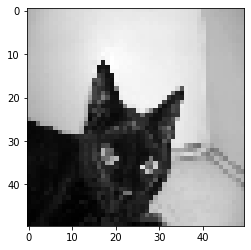

In [5]:
data = Dataset()
data.make_training_data()
print("DONE")

training_data = np.load("../dataset/PetImages/training_data.npy", allow_pickle=True)

# print an example of our dataset
plt.imshow(training_data[1][0], cmap="gray")

### Build NN

* Convnet output dimension: (W-F +2P)/S + 1 
* Pool out dimension: (W-f)/s +1

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 1 * 50 * 50
        self.conv1 = nn.Conv2d(1,6,5) 
        # 6 * 46 * 46
        self.pool1 = nn.MaxPool2d(2,2)
        # 6 * 23 * 23
        self.conv2 = nn.Conv2d(6,16,5)
        # 16 * 19 * 19
        self.pool2 = nn.MaxPool2d(3,2)
        # 16 * 9 * 9
        self.fc1 = nn.Linear(16*9*9, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16*9*9)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)

In [7]:
# print the network architecture
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
X = torch.Tensor([i[0] for i in training_data])
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [9]:
VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training dataset size:", len(train_X))
print("Test dataset size:", len(test_X))

Training dataset size: 22452
Test dataset size: 2494


In [10]:
for epoch in range(EPOCHS):
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    loss_function = nn.MSELoss()
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.zero_grad()
        outputs = net(batch_X.view(-1, 1, 50, 50)) 
        loss = loss_function(outputs, batch_y)  
        loss.backward()  
        optimizer.step() 
    print(loss)
        

  9%|██████▎                                                             | 21/225 [00:00<00:01, 200.87it/s]

tensor(0.2267, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 210.14it/s]

tensor(0.2083, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 212.10it/s]

tensor(0.1856, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 210.11it/s]

tensor(0.1802, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 218.42it/s]

tensor(0.1805, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 213.94it/s]

tensor(0.1867, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 214.11it/s]

tensor(0.1892, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 216.21it/s]

tensor(0.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|██████▋                                                             | 22/225 [00:00<00:00, 218.35it/s]

tensor(0.2027, device='cuda:0', grad_fn=<MseLossBackward>)


100%|███████████████████████████████████████████████████████████████████| 225/225 [00:01<00:00, 212.51it/s]

tensor(0.2068, device='cuda:0', grad_fn=<MseLossBackward>)


### Evaluation

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy :", round(correct/total, 3))

100%|████████████████████████████████████████████████████████████████| 2494/2494 [00:02<00:00, 1151.27it/s]

Accuracy : 0.739


### Run NN on test pictures

* LABELS = {CATS: 0, DOGS: 1} 

It's a dog!


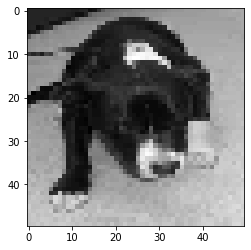

In [14]:
# pick a random image
img_num = random.randrange(2494)
plt.imshow(test_X[img_num], cmap="gray")

img = test_X[img_num].view(-1, 1, 50, 50).to(device)
prediction = torch.argmax(net(img))

if (prediction.tolist() == 0):
    print ("It's a cat!")
else:
    print("It's a dog!")